## **1. Import Libraries and depedencies**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import yfinance as yf
from datetime import datetime
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = 16,9
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['text.color'] = 'k'

## **2. Read/Pre-process/Analyze data**
- **Here, Toyota Motors (TM) stock data is used for analysis. Date range 2018-2023.**

In [2]:
data = yf.download('TM', start='2018-01-01', end='2023-01-01')
print("There are {} rows and {} columns".format(data.shape[0], data.shape[1]))
data.head()

[*********************100%***********************]  1 of 1 completed
There are 1259 rows and 6 columns


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,127.430000,128.429993,127.169998,128.369995,128.369995,83500
2018-01-03,128.679993,130.240005,128.559998,130.130005,130.130005,162200
2018-01-04,131.309998,132.160004,131.300003,132.160004,132.160004,161800
2018-01-05,133.110001,133.869995,133.080002,133.860001,133.860001,135300
2018-01-08,133.979996,134.789993,133.619995,134.770004,134.770004,131200


- **Check if the index of the data is in datetime format. If not, use reset_index and set_index method to do so.**
- **If there are irregularities in time series, try using the mean of a particular period. (week, month, years...)**

In [3]:
stock = data['Adj Close']
stock = stock.reset_index()
stock = stock.set_index('Date')

ts = stock['Adj Close'].resample('MS').mean()

### **Decomposition**

- **Use *time-series decomposition* to decompose and visualize time series into 4 distinct components: level, trend, seasonality, and Residual (Noise).**

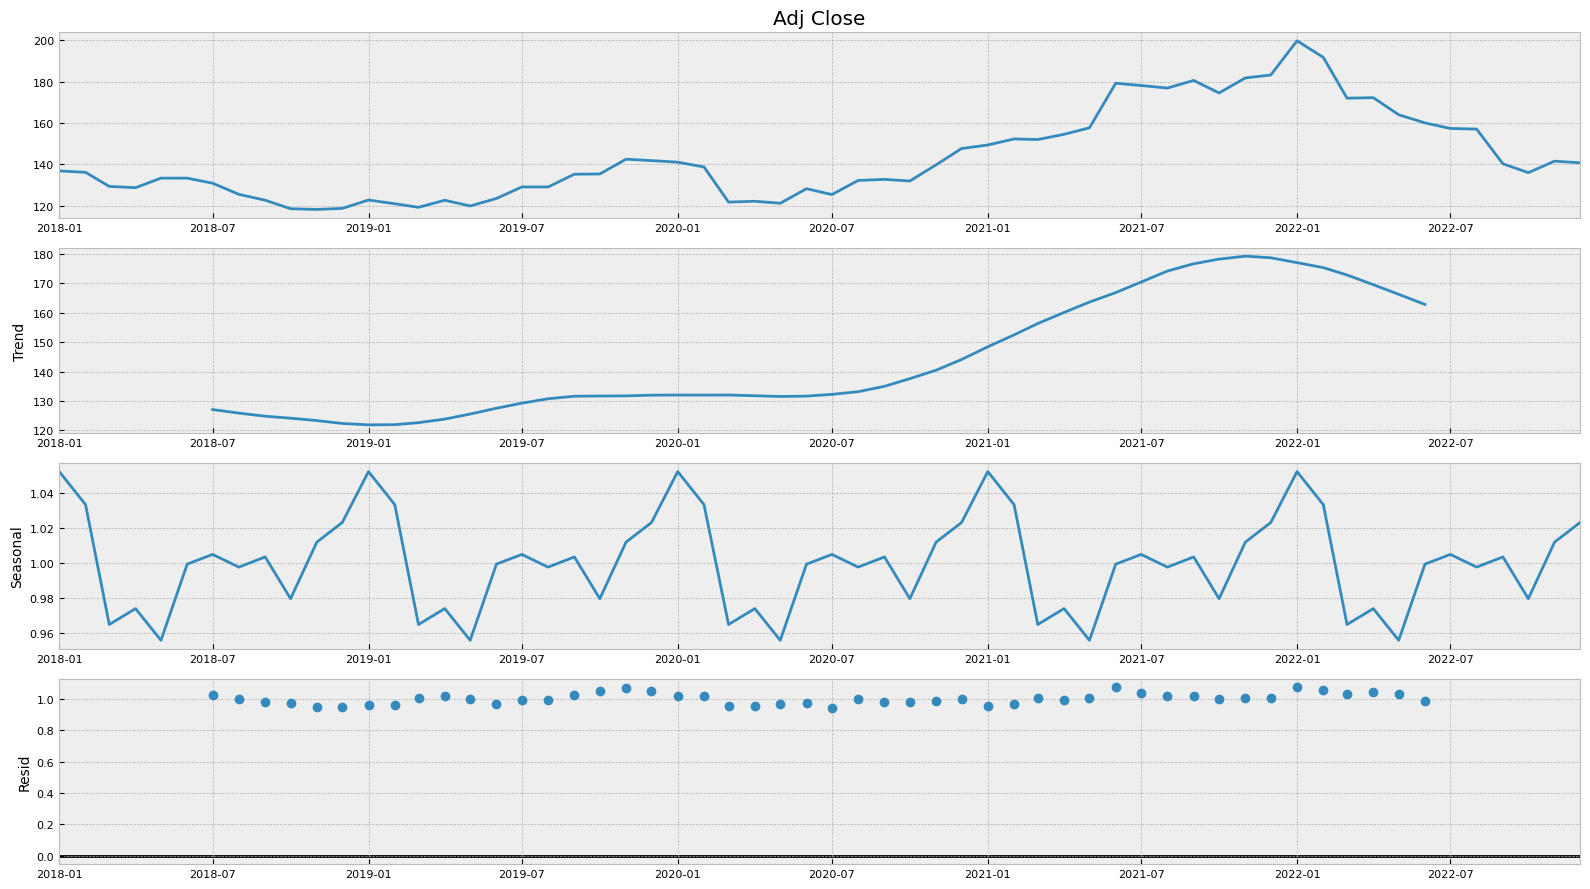

In [4]:
decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative')
result = decomposition.plot()
# plt.tight_layout()
plt.show()

### **Stationarity**

- **There's a non-linear trend with seasonality in the dataset. Residual (Noise) is more or less constant.**
- **To create a prediction model, the dataset must be stationary. In statistical terms, mean and standard deviation should be constant w.r.t time**
- **To make sure if the data is staionary, the following tests can be performed:**
    1. Augmented Dickey-Fuller Test.
    2. Autocorrelation and Partial Auto-correlation Plots
    3. Rolling Mean and Standard deviation

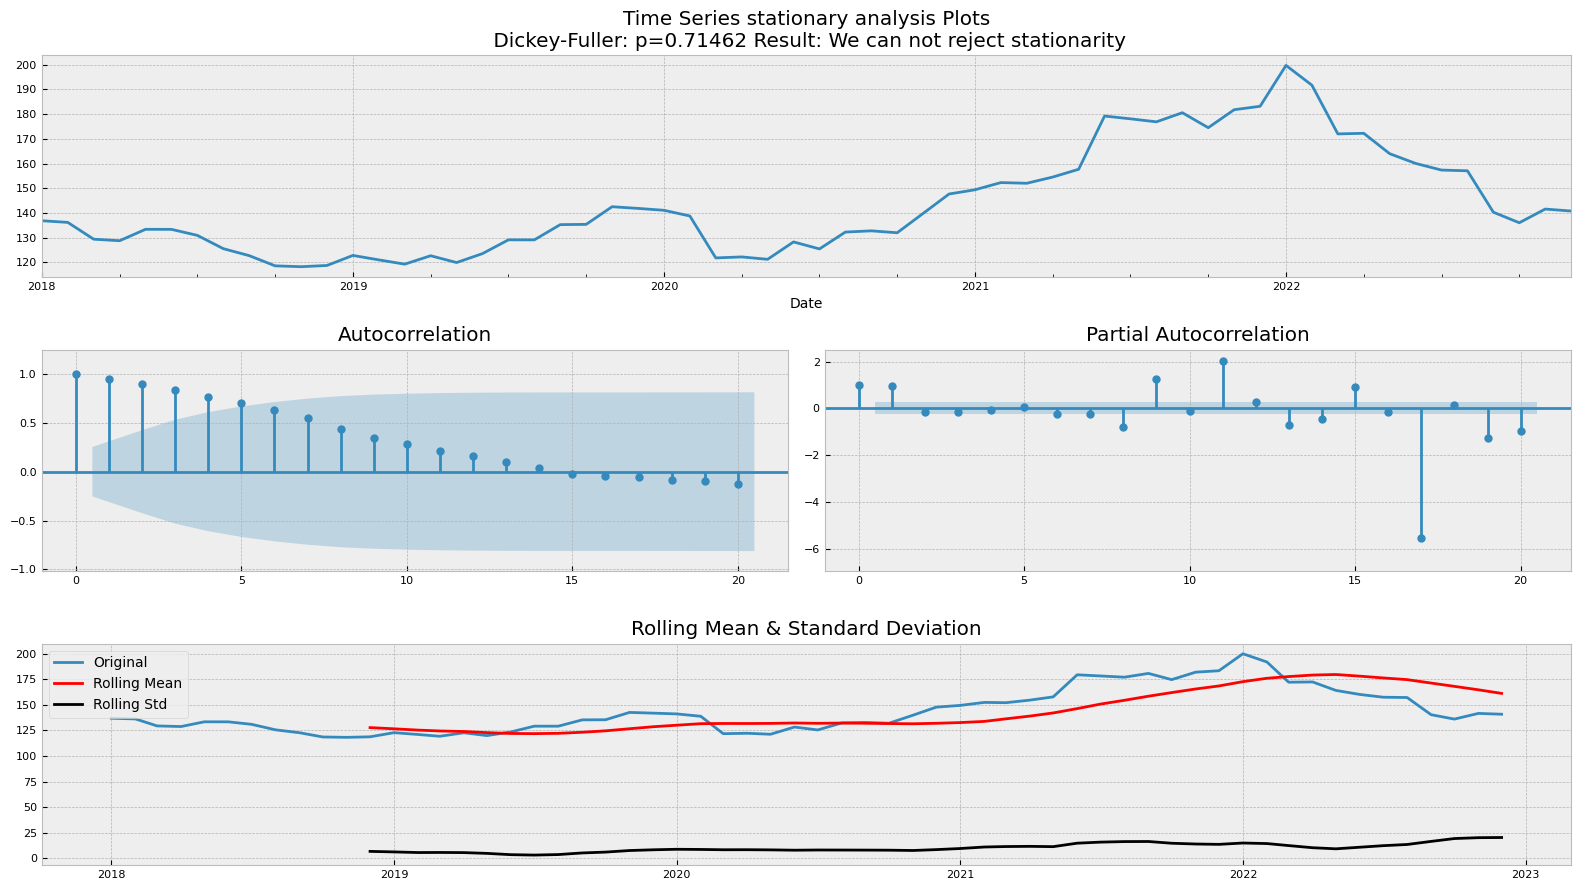

In [5]:
def check_stationary(y, lags=None):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        # fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value <= 0.05 else "We can not reject stationarity"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        sm.tsa.graphics.plot_acf(y, lags=lags, ax=acf_ax, auto_ylims=True)
        sm.tsa.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, auto_ylims=True)
        plt.tight_layout()

        rolmean = y.rolling(window=12).mean()
        rolstd = y.rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(y, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


check_stationary(ts, lags=20)

### **Differencing**

- **The p-value must be <0.05 in order for the data to be stationary. It is greater than that. Therefore, we cannot reject null hypothesis and indeed non-staionary**
- **In order to make the data stationary we use differencing i.e (difference of presentday value  - previousday value)**
- **Use Pandas.shift() to perform it on a whole dataframe.**

In [6]:
# differencing of order 1.
ts_diff = ts - ts.shift()
ts_diff.dropna(inplace=True)
ts_diff.head()

Date
2018-02-01   -0.676893
2018-03-01   -6.809299
2018-04-01   -0.616188
2018-05-01    4.622856
2018-06-01   -0.019523
Freq: MS, Name: Adj Close, dtype: float64

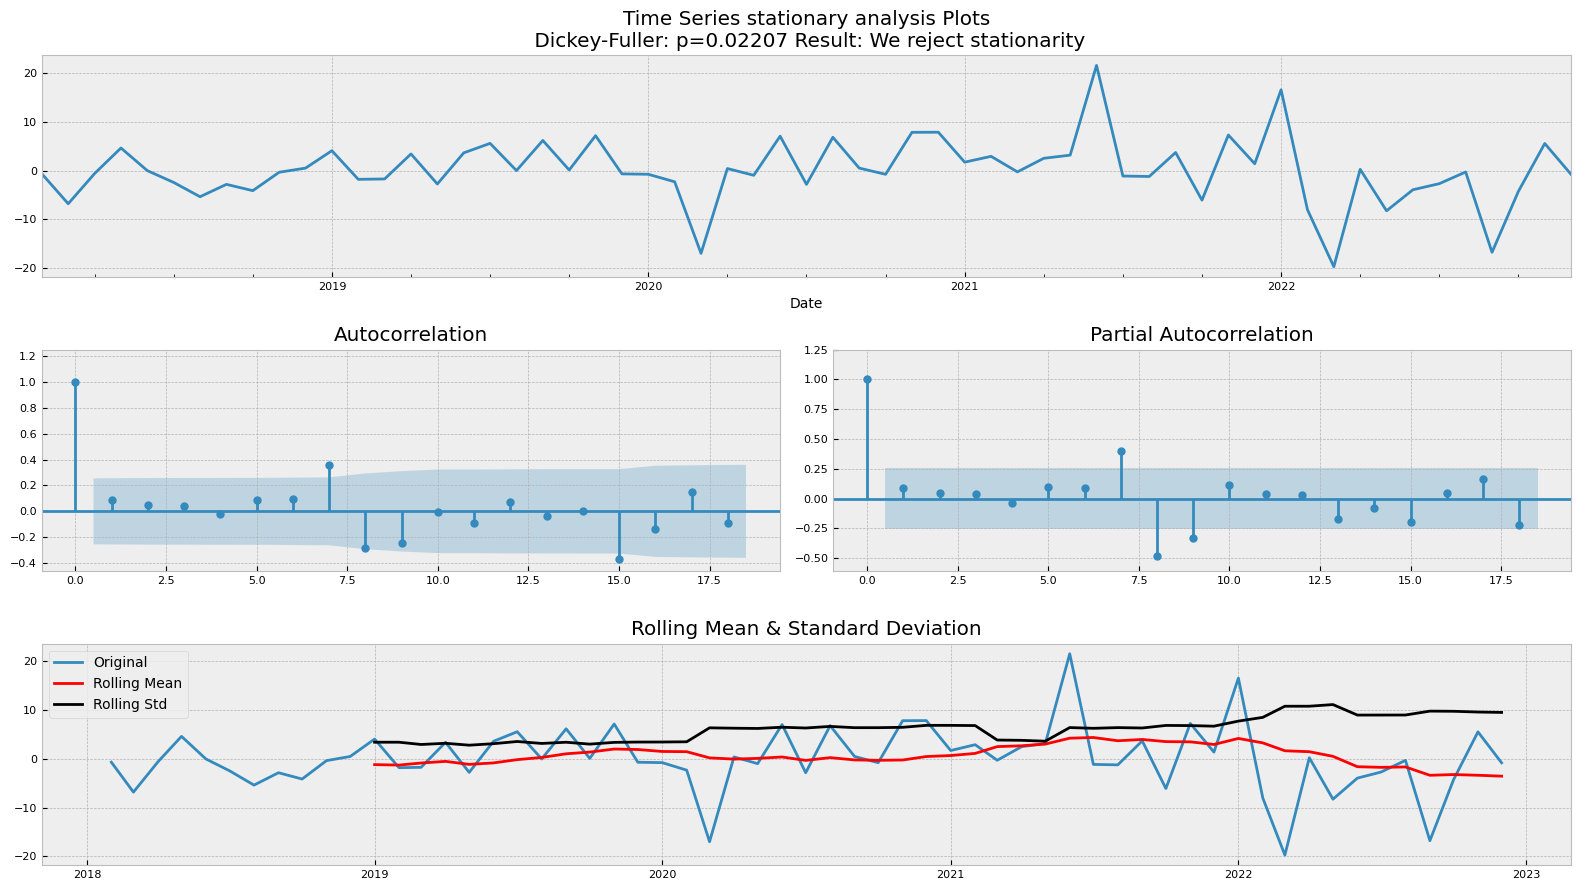

In [7]:
# check staionarity of modified data. (post-differencing)
check_stationary(ts_diff)

In [8]:
# Checking differencing of order 2.
ts_diff2 = ts_diff - ts_diff.shift()
ts_diff2.dropna(inplace=True)
ts_diff2.head()

Date
2018-03-01   -6.132406
2018-04-01    6.193111
2018-05-01    5.239044
2018-06-01   -4.642380
2018-07-01   -2.423335
Freq: MS, Name: Adj Close, dtype: float64

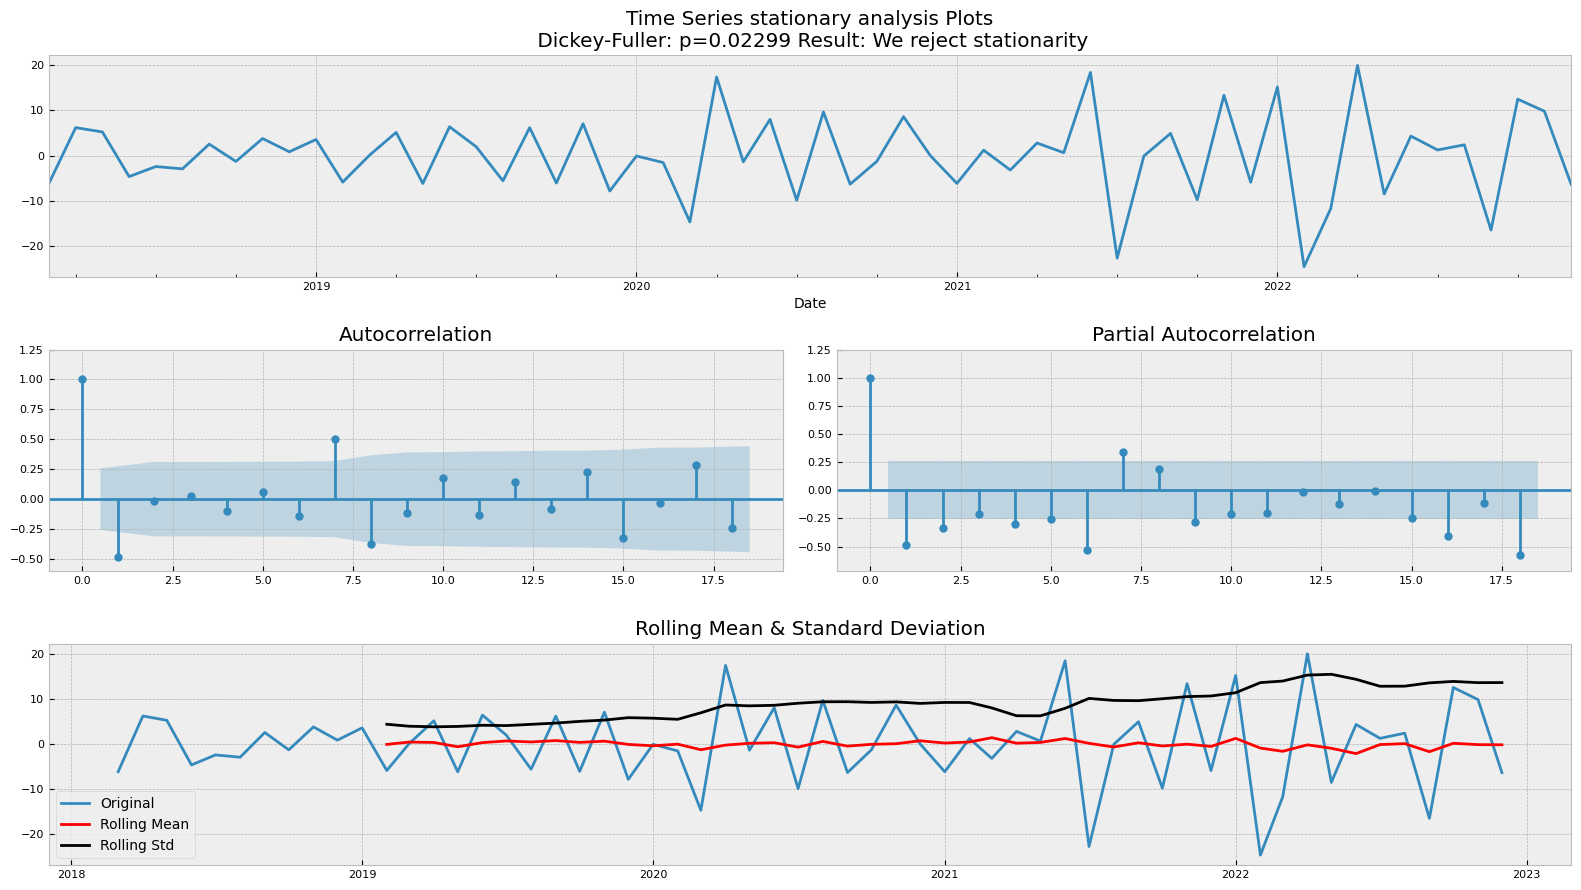

In [9]:
# check staionarity of modified data. (post-differencing of order 2)
check_stationary(ts_diff2)

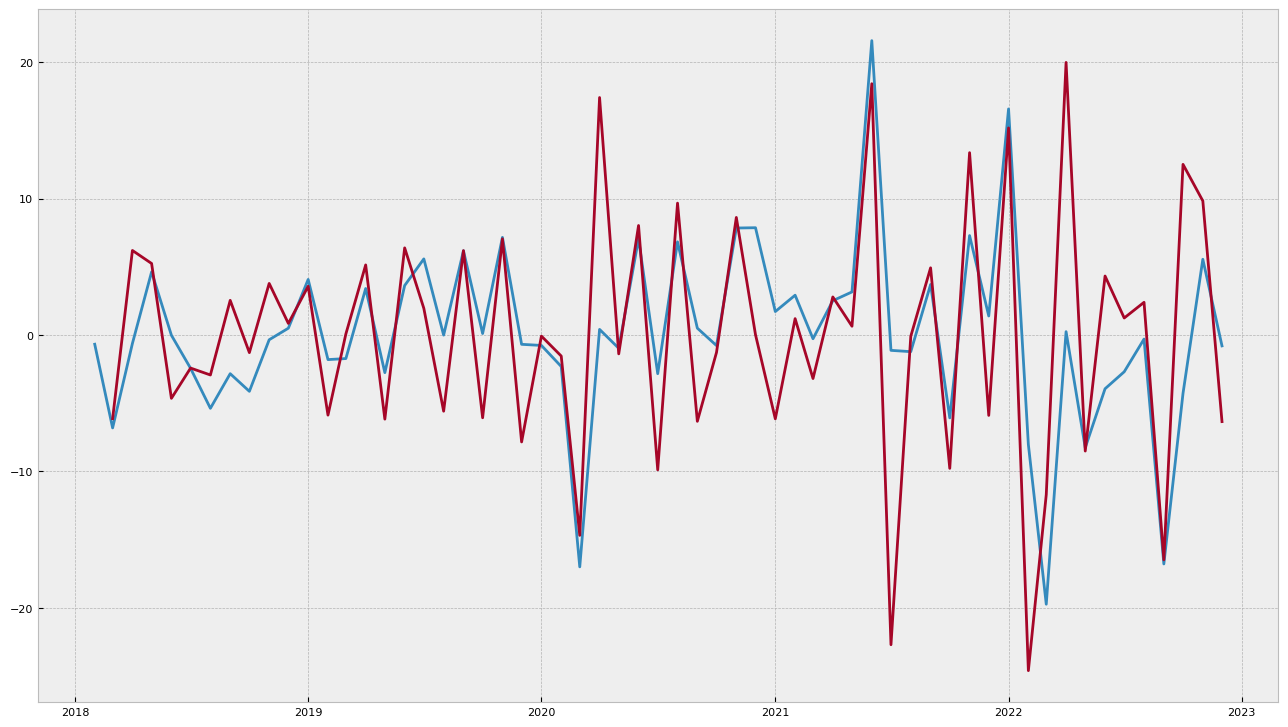

In [10]:
plt.plot(ts_diff)
plt.plot(ts_diff2)

## **3. Build and Train Model**

- **ARIMA NAD SARIMA Model (S-AR-I-MA : seasonal - autoregressive - integrated - movingaverage)**
- **Create a loop to check for the best model parameters. Choose model with lowest AIC.**

In [11]:
def check_order(y):
    
    p = d = q = range(1, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    for param in pdq:
        for params in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=params, enforce_invertibility=False, enforce_stationarity=False)
                res = mod.fit()
                print('SARIMA   {} x {}   AIC:{}'.format(param, params, res.aic))
            except:
                continue
    return res

In [12]:
# check_order(ts_diff)

Text(0.5, 1.0, 'MSE (Mean sqaured error): 40.38345')

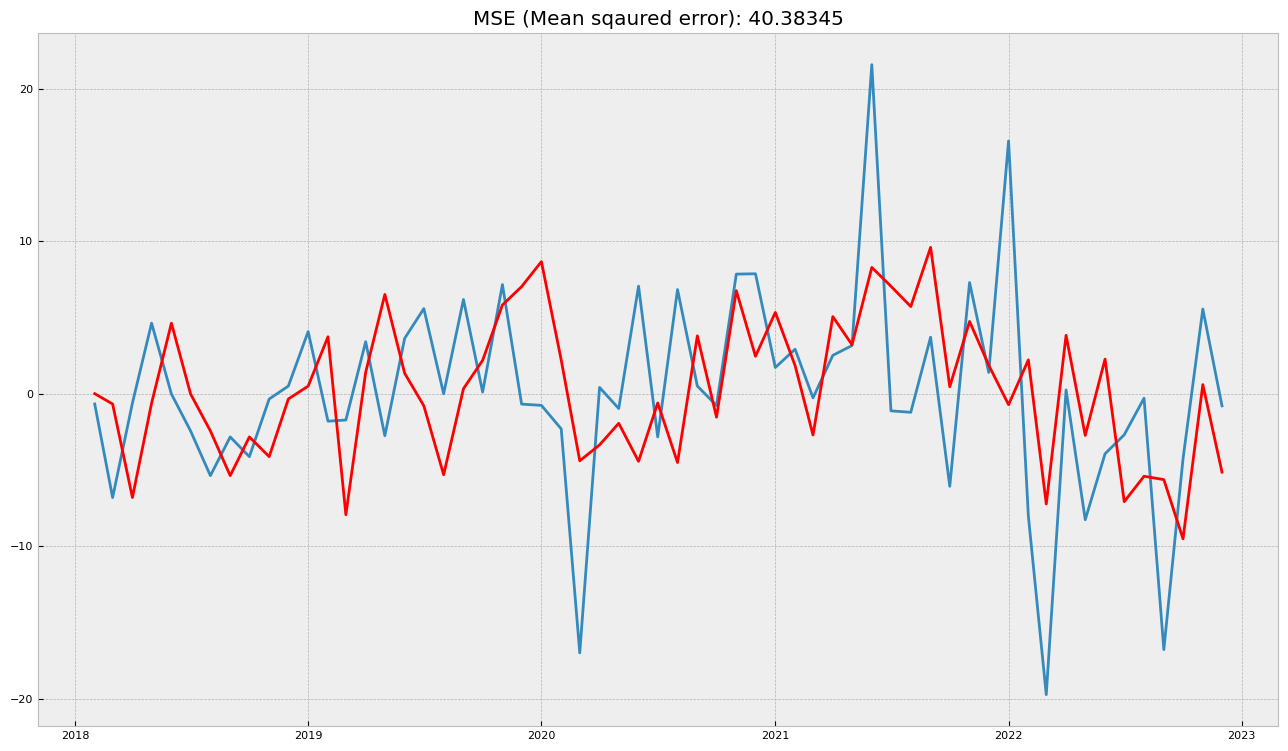

In [13]:
model = sm.tsa.statespace.SARIMAX(ts_diff, order=(2,1,1), seasonal_order=(2,1,1,12))
results = model.fit()
plt.plot(ts_diff)
plt.plot(results.fittedvalues, color='red')
plt.title('MSE (Mean sqaured error): %.5f' % ((results.fittedvalues - ts_diff)**2).mean())

- **Use plot_diagnostics to visualize how the model performed**

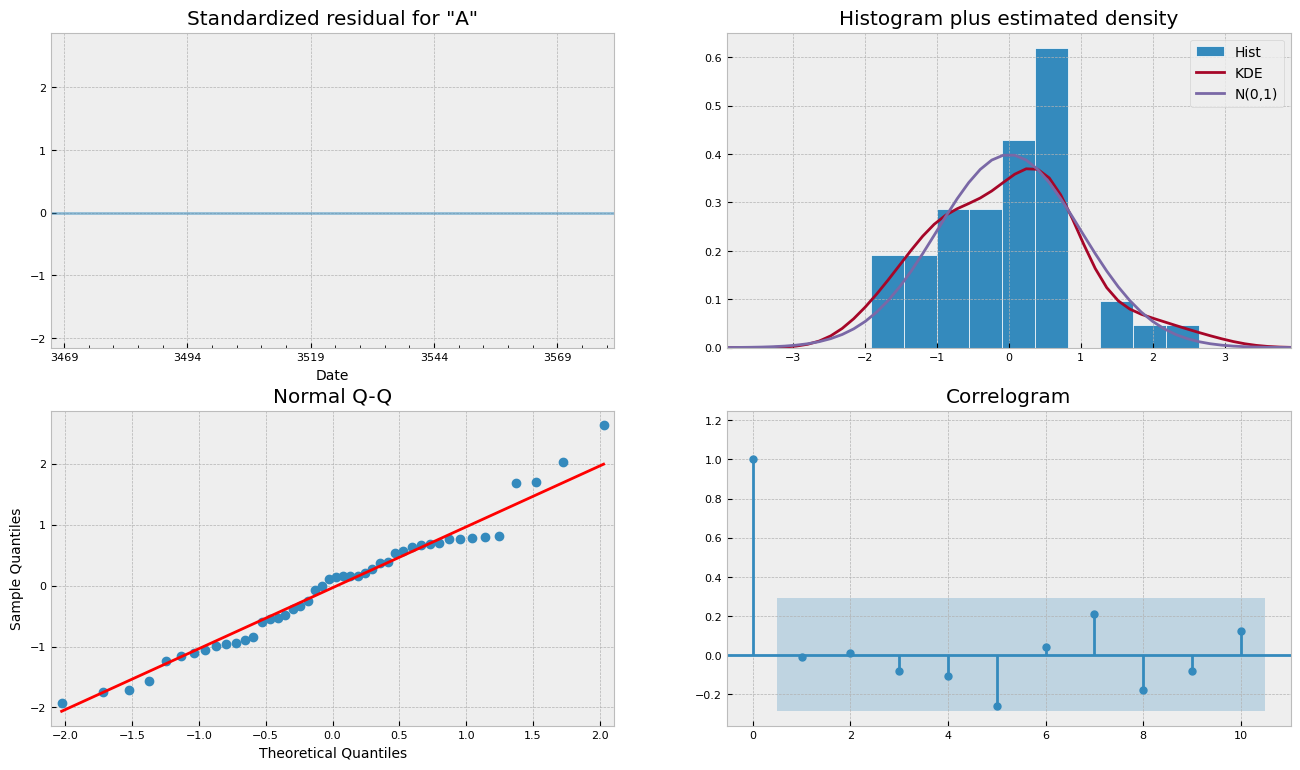

In [14]:
results.plot_diagnostics(auto_ylims=True)
plt.show()

## **4. Validation**

- **Change the scale to it's original value (inverse-transform) / descale.**

In [15]:
predictions_diff = results.fittedvalues
predictions_diff_cumsum = predictions_diff.cumsum()
predictions_SARIMA = pd.Series(ts)
predictions_SARIMA = predictions_SARIMA.add(predictions_diff_cumsum, fill_value=0)
predictions_SARIMA.head()

Date
2018-01-01    136.819523
2018-02-01    136.142630
2018-03-01    128.656458
2018-04-01    121.231337
2018-05-01    125.237714
Freq: MS, dtype: float64

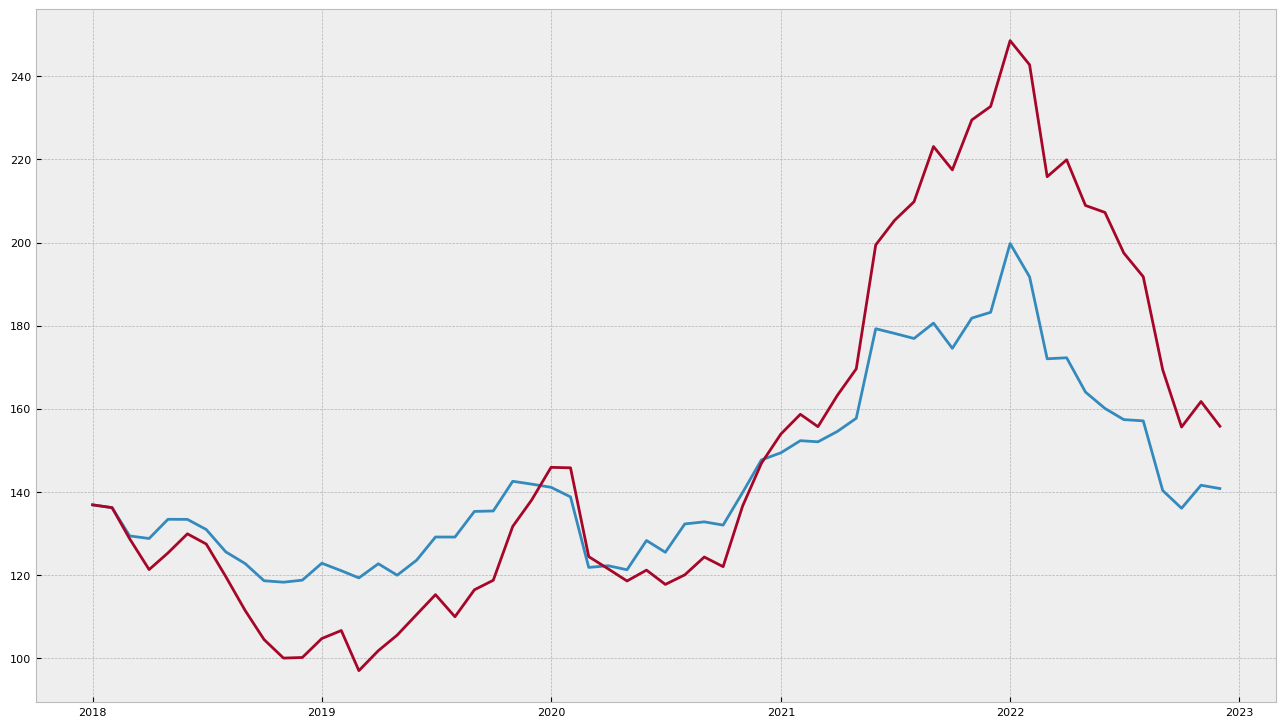

In [16]:
plt.plot(ts)
plt.plot(predictions_SARIMA)

- **Use RMSE metrics to validate the accuracy of prediction model.**

Text(0.5, 1.0, 'RMSE: 23.7812')

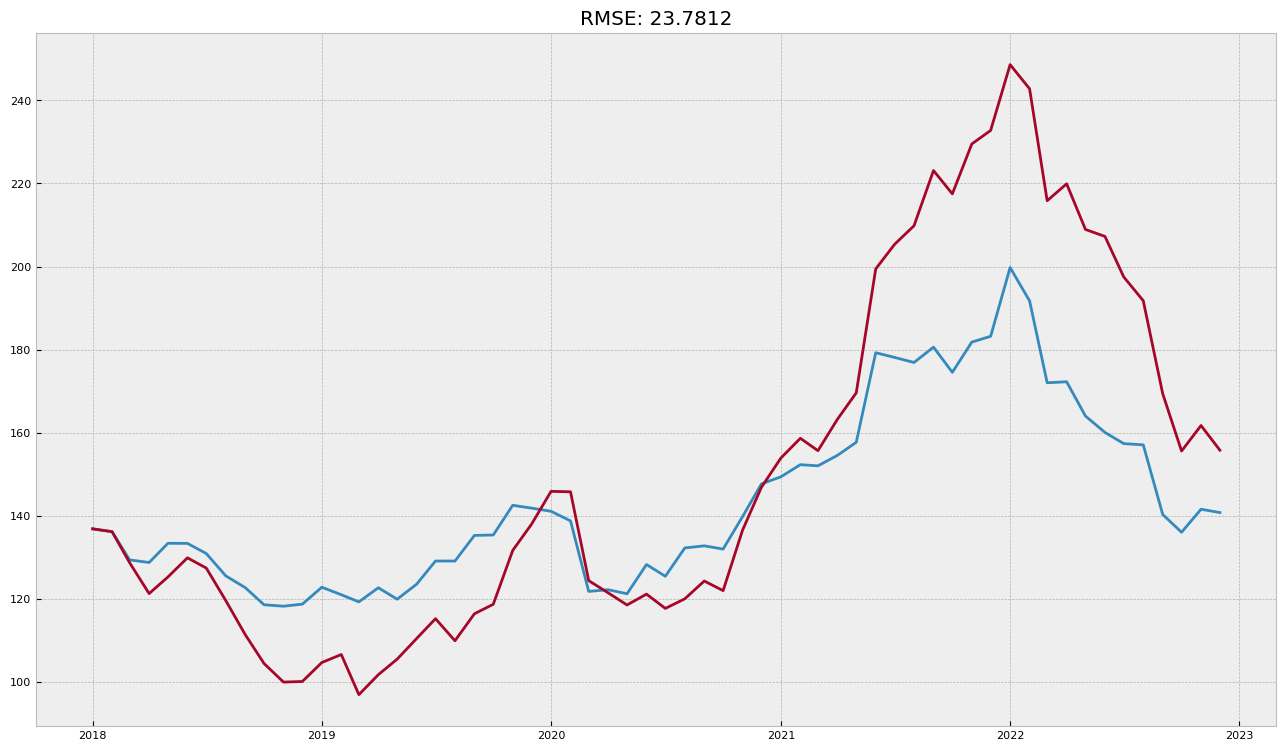

In [17]:
plt.plot(ts)
plt.plot(predictions_SARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_SARIMA-ts)**2)/len(ts)))